# ML model in pytorch:

## Setting up:
### Additional installations

In [1]:
! pip install cartopy
! pip install pyproj
! pip install wandb
! pip uninstall shapely
! pip install shapely --no-binary shapely

     |████████████████████████████████| 10.8 MB 5.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 22.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 28.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 61.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 4.2 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516314 sha256=05ead8746b876ca8a218980643c09d3c8160137c49a8c01afd0778216a256417
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
Successfully built cartopy
     |███

### Imports:

In [2]:
# Basics
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import os
import sys
from pathlib import Path
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from re import search
from math import cos,sin,pi
import random as rn
from google.colab import auth

# xarray and cartopy plots
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import pyproj
from pyproj import Transformer

# ML
from scipy import ndimage
import torch
import tensorflow as tf 
import torch.nn as nn
import torch.nn.functional as F
import argparse
import logging
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split
#import setGPU

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up CUDA:

In [3]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
if torch.cuda.is_available():
  cuda_id = torch.cuda.current_device()
  print(f"ID of current CUDA device:{torch.cuda.current_device()}")
          
  print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? True
CUDA version: 11.3
ID of current CUDA device:0
Name of current CUDA device:Tesla P100-PCIE-16GB


### Helper scripts:

In [11]:
# Load configuration file:
from config import *
from helperFunctions import *

# Import custom scripts
#sys.path.append('../')
from GC_scripts import * # Google cloud scripts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up Google Cloud:

In [12]:
auth.authenticate_user()
# Give our project ID
project_id = 'ee-iceshelf-gee4geo'
!gcloud config set project {project_id}
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt
# Print the result to make sure the transfer worked.
!cat /tmp/gsutil_download.txt

Updated property [core/project].
Copying gs://ee-downscalingclimatemodels/test.txt...
/ [1 files][   13.0 B/   13.0 B]                                                
Operation completed over 1 objects/13.0 B.                                       
AIAIAIAIAIAIA

## Load data:

### (Input) Global climate model:

In [13]:
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileGCMLike)
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
else:
    GCMLike = xr.open_dataset(pathCluster + fileGCMLike)
print(GCMLike.dims)
GCMLike

Frozen(SortedKeysDict({'x': 90, 'y': 25, 'time': 1452}))


<xarray.Dataset>
Dimensions:      (time: 1452, x: 90, y: 25)
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
Data variables:
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 ...
    VVP          (time, y, x) float64 ...
    UUP          (time, y, x) float64 ...
Attributes:
    crs:      3031

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarnin

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:556: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be rem

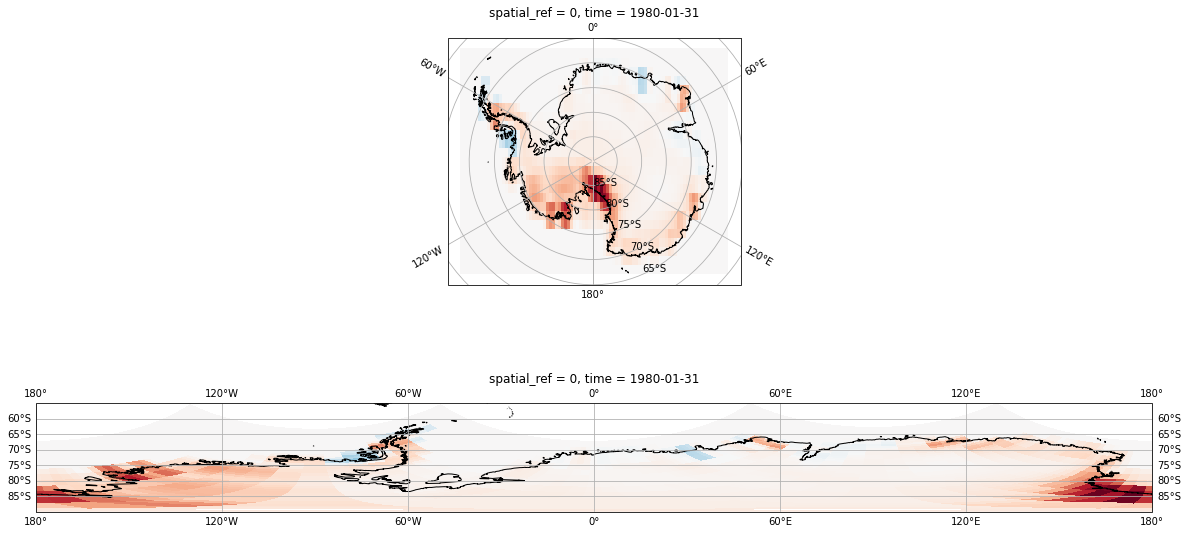

In [14]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(2, 1, 1, projection=ccrs.SouthPolarStereo())
GCMLike.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=False
)
ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

ax = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
GCMLike.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=False
)
ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

### (Target) Regional climate model:

In [15]:
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileTarget)
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
else:
    target_dataset = xr.open_dataset(pathCluster + fileTarget)
print(target_dataset.dims)

# Cut a small part of on the right that is not too important
N = 160
max_x = (N / 2) * 35 * 1000
max_y = (N / 2) * 35 * 1000

target_dataset = cutBoundaries(target_dataset, max_x, max_y)
print("New target dimensions:", target_dataset.dims)

Frozen(SortedKeysDict({'time': 1452, 'y': 148, 'x': 176, 'PLEV': 7}))
New target dimensions: Frozen(SortedKeysDict({'time': 1452, 'y': 148, 'x': 160, 'PLEV': 7}))


## Input and target for model:

**Z**:
- (ignore for now) External forcing also given to RCM → total concentration of greenhouse gases and solar and ozone forcings
- Cosinus, sinus vector to encode information about day of year
- Daily spatial means and standard deviations time series for each $X_{i,j,m}$ (because normalising 2D variables removes temporal information)

**X**: 
SHAPE `[nbmonths, x, y, nb_vars]`

For pytorch need to put into `[nbmonths, nb_vars, x, y]`

### Input:

In [16]:
def input_maker(
    GCMLike,
    size_input_domain=16,  # size of domain, format: 8,16,32, must be defined in advance
    stand=True,  # standardization
    seas=True,  # put a cos, sin vector to control the season, format : bool
    means=True,  # add the mean of the variables raw or stdz, format : bool
    stds=True,  # add the std of the variables raw or stdz, format : bool
    resize_input=True,  # resize input to size_input_domain
    region="Larsen",  # region of interest
    regionNbr=0, # number of region of interest
    print_=True,
    reg = True # encoding of region
):

    if region != "Whole Antarctica":
        DATASET = createLowerInput(GCMLike, region=region, Nx=48, Ny=25, print_=False)
    else:
        DATASET = GCMLike
    """
    MAKE THE 2D INPUT ARRAY
    SHAPE [nbmonths, x, y, nb_vars]
    """

    # Remove target variable from DATASET:
    DATASET = DATASET.drop(["SMB"])

    nbmonths = DATASET.dims["time"]
    x = DATASET.dims["x"]
    y = DATASET.dims["y"]
    nb_vars = len(list(DATASET.data_vars))
    VAR_LIST = list(DATASET.data_vars)

    INPUT_2D_bf = np.transpose(
        np.asarray([DATASET[i].values for i in VAR_LIST]), [1, 2, 3, 0]
    )

    # if no size is given, take smallest power of 2
    if size_input_domain == None:
        size_input_domain = np.max(
            [
                highestPowerof2(INPUT_2D_bf.shape[1]),
                highestPowerof2(INPUT_2D_bf.shape[2]),
            ]
        )

    if resize_input:
        # resize to size_input_domain
        INPUT_2D = resize(INPUT_2D_bf, size_input_domain, size_input_domain, print_)
    else:
        INPUT_2D = INPUT_2D_bf

    if stand:
        # Standardize:
        INPUT_2D_SDTZ = standardize(INPUT_2D)
        # in their code with aerosols extra stuff but ignore
        INPUT_2D_ARRAY = INPUT_2D_SDTZ
    else:
        INPUT_2D_ARRAY = INPUT_2D

    if print_:
        print("Parameters:\n -------------------")
        print("Size of input domain:", size_input_domain)
        print("Region:", region)
        print("\nCreating 2D input X:\n -------------------")
        print(f"Number of variables: {nb_vars}")
        print(f"Variables: {VAR_LIST}")
        print(f"INPUT_2D shape: {INPUT_2D_ARRAY.shape}")
        print("\nCreating 1D input Z:\n -------------------")

    """
    MAKE THE 1D INPUT ARRAY
    CONTAINS MEANS, STD SEASON IF ASKED
    """

    INPUT_1D = []
    if means and stds:
        vect_std = INPUT_2D.std(axis=(1, 2))
        vect_means = INPUT_2D.mean(axis=(1, 2))
        SpatialMean = vect_means.reshape(INPUT_2D.shape[0], 1, 1, INPUT_2D.shape[3])
        SpatialSTD = vect_std.reshape(INPUT_2D.shape[0], 1, 1, INPUT_2D.shape[3])

        INPUT_1D.append(SpatialMean)
        INPUT_1D.append(SpatialSTD)
        if print_:
            print(f"SpatialMean/std shape: {SpatialMean.shape}")

    if seas:
        months = 12
        cosvect = np.tile(
            [cos(2 * i * pi / months) for i in range(months)],
            int(INPUT_2D.shape[0] / months),
        )
        sinvect = np.tile(
            [sin(2 * i * pi / months) for i in range(months)],
            int(INPUT_2D.shape[0] / months),
        )
        cosvect = cosvect.reshape(INPUT_2D.shape[0], 1, 1, 1)
        sinvect = sinvect.reshape(INPUT_2D.shape[0], 1, 1, 1)

        INPUT_1D.append(cosvect)
        INPUT_1D.append(sinvect)
        if print_:
            print(f"Cos/sin encoding shape: {cosvect.shape}")
    if reg: 
        regvect = np.array([regionNbr for i in range(INPUT_2D.shape[0])])
        regvect = cosvect.reshape(INPUT_2D.shape[0], 1, 1, 1)
        INPUT_1D.append(regvect)
        
    INPUT_1D_ARRAY = np.concatenate(INPUT_1D, axis=3)
    if print_:
        print(f"INPUT_1D shape: {INPUT_1D_ARRAY.shape}")

    DATASET.close()
    return INPUT_2D_ARRAY, INPUT_1D_ARRAY, VAR_LIST

In [17]:
def make_inputs(GCMLike, Size_input_domain, Region, regionNbr):
    # Make input
    i2D, i1D, VAR_LIST = input_maker(
        GCMLike=GCMLike,
        size_input_domain=Size_input_domain,
        stand=True,  # standardization
        seas=True,  # put a cos,sin vector to control the season, format : bool
        means=True,  # add the mean of the variables raw or stdz, format : r,s,n
        stds=True,
        resize_input=True,
        region=Region,
        regionNbr=regionNbr,
        print_=False,
        reg = True
    )

    # Make a non standardised version for plots:
    i2D_ns, i1D_ns, var_list = input_maker(
        GCMLike=GCMLike,
        size_input_domain=Size_input_domain,
        stand=False,  # standardization
        seas=True,  # put a cos,sin vector to control the season, format : bool
        means=True,  # add the mean of the variables raw or stdz, format : r,s,n
        stds=True,
        resize_input=False,
        region=Region,
        regionNbr=regionNbr,
        print_=False,
        reg = True
    )
    return i1D, i2D, i1D_ns, i2D_ns, VAR_LIST

In [18]:
# Download GMC like RCM input data:
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileGCMLike)
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
else:
    GCMLike = xr.open_dataset(pathCluster + fileGCMLike)

if REGION == "Combined":
    inputs_2D = []
    inputs_1D = []
    inputs_2D_ns = []
    inputs_1D_ns = []
    i = 0
    for r in REGIONS:
        i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
            GCMLike, SIZE_INPUT_DOMAIN, Region=r, regionNbr=i
        )
        inputs_1D.append(i1D)
        inputs_2D.append(i2D)
        inputs_1D_ns.append(i1D_ns)
        inputs_2D_ns.append(i2D_ns)
        i+=1
else:
    i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
        GCMLike, SIZE_INPUT_DOMAIN, Region=REGION, regionNbr = 0
    )
    inputs_2D_ns = [i2D_ns]
    inputs_1D_ns = [i1D_ns]
    inputs_2D = [i2D]
    inputs_1D = [i1D]
    REGIONS = [REGION]

# Full input to model
full_input = [np.concatenate(inputs_2D, axis=0), np.concatenate(inputs_1D, axis=0)]
full_input_ns = [
    np.concatenate(inputs_2D_ns, axis=0),
    np.concatenate(inputs_1D_ns, axis=0),
]

### Target:

In [19]:
def target_maker(
    target_dataset,
    region="Larsen",  # region of interest
    resize=True,  # resize to target_size
    target_size=None,  # if none provided and resize true, set to min highest power of 2
):
    target_times = []
    targets = []

    if region != "Whole antarctica":
        lowerTarget = createLowerTarget(
            target_dataset, region=region, Nx=64, Ny=64, print_=False
        )
        targetArray = lowerTarget.SMB.values
    else:
        targetArray = target_dataset.SMB.values

    targetArray = targetArray.reshape(
        targetArray.shape[0], targetArray.shape[1], targetArray.shape[2], 1
    )

    if target_size == None:
        # resize to highest power of 2:
        target_size = np.min(
            [
                highestPowerof2(targetArray.shape[1]),
                highestPowerof2(targetArray.shape[2]),
            ]
        )

    if resize:
        target_SMB = resize(targetArray, target_size, target_size)
    else:
        target_SMB = targetArray

    targets.append(target_SMB)
    target_times.append(target_dataset.time.values)

    return targets, target_times

In [20]:
if REGION == "Combined":
    targets, target_times = [], []
    for r in REGIONS:
        t, t_times = target_maker(target_dataset, region=r, resize=False)
        targets.append(t[0])
        target_times.append(t_times[0])
else:
    targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

In [21]:
print("Shapes of targets and inputs:\n---------------------------")
print("Target:", full_target.shape)
print("Input 2D:", full_input[0].shape)
print("Input 1D:", full_input[1].shape)

Shapes of targets and inputs:
---------------------------
Target: (1452, 64, 64, 1)
Input 2D: (1452, 32, 32, 7)
Input 1D: (1452, 1, 1, 17)


### Example of each region of Antarctica:
Plot an example of each region that is used.

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


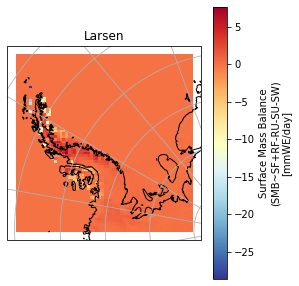

In [22]:
f = plt.figure(figsize=(20, 5))
i = 1
for r in REGIONS:
    targets, target_times = target_maker(target_dataset, region=r, resize=False)
    full_target_test = np.concatenate(targets, axis=0)[0, :, :, :]
    ax = plt.subplot(1, 4, i, projection=ccrs.SouthPolarStereo())
    vmin = np.min(full_target_test)
    vmax = np.max(full_target_test)
    plotTarget(target_dataset, full_target_test, ax, vmin, vmax, region=r)
    ax.set_title(r)
    i += 1

### Create pytorch tensors:

In [23]:
X = torch.tensor(full_input[0].transpose(0, 3, 1, 2))
Z = torch.tensor(full_input[1].transpose(0, 3, 1, 2))
Y = torch.tensor(full_target.transpose(0, 3, 1, 2))
X.shape, Z.shape, Y.shape

(torch.Size([1452, 7, 32, 32]),
 torch.Size([1452, 17, 1, 1]),
 torch.Size([1452, 1, 64, 64]))

Create encoding of regions so that each sample has a number that indicates which region of Antarctica it corresponds to.

In [24]:
def regionEncoder(REGION):
  # Indicator of regions and their order if combined dataset
  # Encoding 0-> Num regions
  regions = []
  if REGION == "Combined":
      N = int(len(X) / len(REGIONS))
      for j in range(len(REGIONS)):
          for i in range(N):
              regions.append(j)
  else:
      N = len(X)
      regions = [0 for i in range(N)]
  R = torch.tensor(regions) # Change to tensor
  return R

In [25]:
# Test
R = regionEncoder(REGION)
len(R)

1452

## Create dataset:
Show an example of process of how dataset is

In [26]:
# 1. Create dataset
dataset = TensorDataset(X, Z, Y, R)
loader = DataLoader(dataset, batch_size=BATCH_SIZE)

# Example:
(x, z, y, r) = next(iter(loader))
print(f"2D Feature batch shape: {x.size()}")
print(f"1D Feature batch shape: {z.size()}")
print(f"Labels batch shape: {y.size()}")

# 2. Split into train / validation partitions
n_val = int(len(dataset) * VAL_PERCENT)
n_train = len(dataset) - n_val
train_set, val_set = random_split(
    dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED)
)

# 3. Create data loaders
loader_args = dict(batch_size=BATCH_SIZE)
train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_set, shuffle=False, batch_size=BATCH_SIZE)

2D Feature batch shape: torch.Size([32, 7, 32, 32])
1D Feature batch shape: torch.Size([32, 17, 1, 1])
Labels batch shape: torch.Size([32, 1, 64, 64])


### Examples of input to model:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

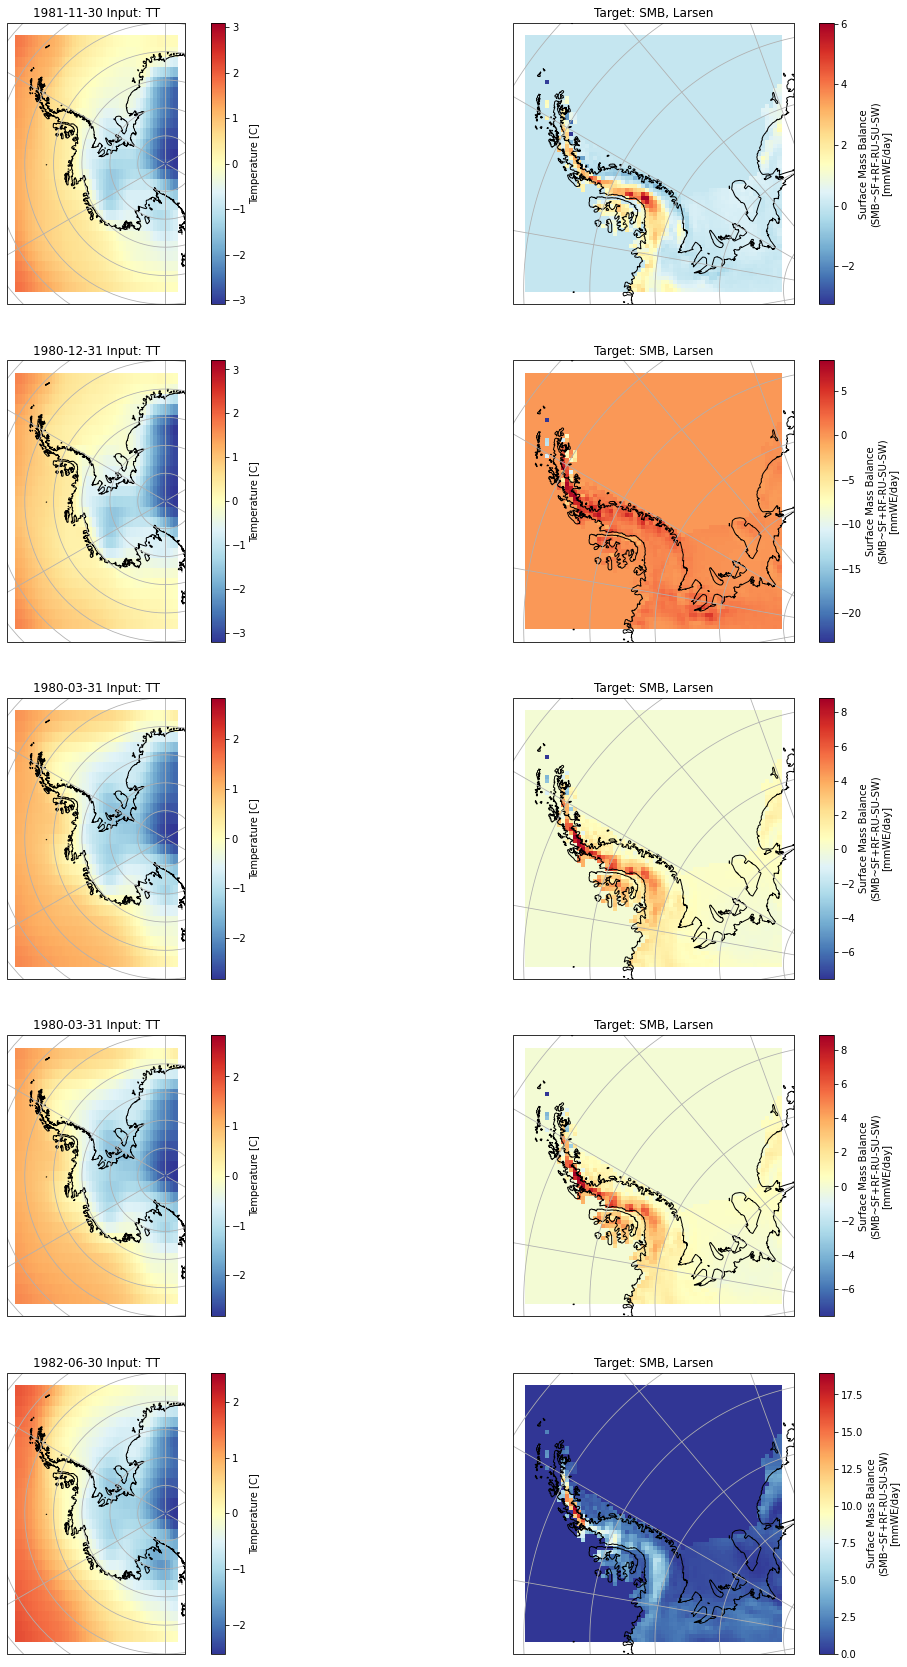

In [27]:
# 4. Display input and targets.
N = 5 
f = plt.figure(figsize=(20, 30))

for i in range(N):
  train_X, train_Z, train_Y, train_R = next(iter(loader))
  randTime = rn.randint(0, len(train_X)-1)
  sample2dtrain_ = train_X.numpy().transpose(0, 2, 3, 1)[randTime]
  sampletarget_ = train_Y.numpy().transpose(0, 2, 3, 1)[randTime]
  sampleregion = train_R[randTime]
  dt = pd.to_datetime([GCMLike.time.isel(time=randTime).values])
  time = str(dt.date[0])

  if REGION != "Whole Antarctica":
      sample2dtrain_ = resize(sample2dtrain_, 25, 48, print_=False)
  else:
      sample2dtrain_ = resize(sample2dtrain_, 25, 90, print_=False)
  vmin = np.min(sampletarget_)
  vmax = np.max(sampletarget_)

  M = 2
  for m in range(M):
    if m == 0:
      ax = plt.subplot(N, 2, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
      plotTrain(GCMLike, sample2dtrain_, 4, ax, time, VAR_LIST, region=REGIONS[sampleregion])
    if m == 1:
      ax = plt.subplot(N, 2, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
      plotTarget(target_dataset, sampletarget_, ax, vmin, vmax, region=REGIONS[sampleregion])

## U-Net:

### Architecture:

In [28]:
# import architecture from py files
from unet import *

In [29]:
# Test of U-Net:
n_channels_x = 7
n_channels_z = 17
size = 32
filter = 64

unet = UNetMarijn(
    n_channels_x=n_channels_x,
    n_channels_z=n_channels_z,
    size=size,
    filter=filter,
    bilinear=False,
)

train_X, train_Z, train_Y, train_R = next(iter(train_loader))
x = unet(train_X, train_Z)
x.shape, train_X.shape, train_Z.shape, train_R.shape

(torch.Size([32, 1, 64, 64]),
 torch.Size([32, 7, 32, 32]),
 torch.Size([32, 17, 1, 1]),
 torch.Size([32]))

## Training

In [35]:
# Load configuration file:
from config import *
from helperFunctions import *
from training_functions import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Scenario 1: 1 region

#### Larsen:

In [ ]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device {device}")

n_channels_x = 7
n_channels_z = 17
size = 32
filter = 64
load = False  # type=str, default=False, Load model from a .pth file

dir_checkpoint = Path("./checkpoints/")

net = UNetMarijn(
    n_channels_x=n_channels_x,
    n_channels_z=n_channels_z,
    size=size,
    filter=filter,
    bilinear=False,
)

logging.info(
    f"Network:\n"
    f"\t{net.n_channels_x} input channels X\n"
    f"\t{net.n_channels_z} input channels Z\n"
    f"\t{net.size} size\n"
    f"\t{net.filter} filter\n"
    f'\t{"Bilinear" if net.bilinear else "Transposed conv"} upscaling'
)


if load:  # Load model from a .pth file
    net.load_state_dict(torch.load(load, map_location=device))
    logging.info(f"Model loaded from {load}")

net.to(device=device)

# 1. Create dataset:
X = torch.tensor(full_input[0].transpose(0, 3, 1, 2))
Z = torch.tensor(full_input[1].transpose(0, 3, 1, 2))
Y = torch.tensor(full_target.transpose(0, 3, 1, 2))

# Indicator of regions and their order if combined dataset
# Encoding 0-> Num regions
R = regionEncoder(REGION)

# Create dataset:
dataset = TensorDataset(X, Z, Y, R)

# 2. Split into test and train/val set:
n_test = int(len(dataset) * TEST_PERCENT)
n_train = len(dataset) - n_test
logging.info(f"Test set size: {n_test}\n" f"Train set size: {n_train}\n")
train_set, test_set = random_split(
    dataset, [n_train, n_test], generator=torch.Generator().manual_seed(SEED)
)

# 3. Train
train_loss_e, val_loss_e = train_net(
        net=net,
        dataset=train_set,
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=LR,
        device=device,
        val_percent=VAL_PERCENT,
        amp=AMP,
        dir_checkpoint = Path("./checkpoints/"), 
        region = REGION)

INFO: Using device cuda
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 261
Validation set size: 1046



<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO: Starting training:
		Epochs:          100
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 1/100: 100%|██████████| 1046/1046 [00:09<00:00, 110.71timestep/s, loss (batch)=2.02]
INFO: Checkpoint 1 saved!
Epoch 2/100: 100%|██████████| 1046/1046 [00:08<00:00, 120.47timestep/s, loss (batch)=1.34]
INFO: Checkpoint 2 saved!
Epoch 3/100:  58%|█████▊    | 608/1046 [00:04<00:03, 112.47timestep/s, loss (batch)=1.7]

In [ ]:
plotLoss(train_loss_e['MSE'], val_loss_e['MSE'])

In [ ]:
plotLoss(train_loss_e['RMSE'], val_loss_e['RMSE'], 'RMSE')

##### Prediction:

In [ ]:
loader_args = dict(batch_size=1, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=True, **loader_args)
today = str(date.today())
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds, x, z, true_smb, r = predict(net, device, test_loader, model)

In [ ]:
plotRandomPredictions(preds, x, z, true_smb, r, GCMLike, VAR_LIST, target_dataset, N=10)

#### Maud:

In [ ]:
REGION = 'Maud'

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device {device}")

n_channels_x = 7
n_channels_z = 17
size = 32
filter = 64
load = False  # type=str, default=False, Load model from a .pth file

dir_checkpoint = Path("./checkpoints/")

net = UNetMarijn(
    n_channels_x=n_channels_x,
    n_channels_z=n_channels_z,
    size=size,
    filter=filter,
    bilinear=False,
)

logging.info(
    f"Network:\n"
    f"\t{net.n_channels_x} input channels X\n"
    f"\t{net.n_channels_z} input channels Z\n"
    f"\t{net.size} size\n"
    f"\t{net.filter} filter\n"
    f'\t{"Bilinear" if net.bilinear else "Transposed conv"} upscaling'
)

if load:  # Load model from a .pth file
    net.load_state_dict(torch.load(load, map_location=device))
    logging.info(f"Model loaded from {load}")

net.to(device=device)

# 1. Create dataset:
X = torch.tensor(full_input[0].transpose(0, 3, 1, 2))
Z = torch.tensor(full_input[1].transpose(0, 3, 1, 2))
Y = torch.tensor(full_target.transpose(0, 3, 1, 2))

# Indicator of regions and their order if combined dataset
# Encoding 0-> Num regions
R = regionEncoder(REGION)

# Create dataset:
dataset = TensorDataset(X, Z, Y, R)

# 2. Split into test and train/val set:
n_test = int(len(dataset) * TEST_PERCENT)
n_train = len(dataset) - n_test
logging.info(f"Test set size: {n_test}\n" f"Train set size: {n_train}\n")
train_set, test_set = random_split(
    dataset, [n_train, n_test], generator=torch.Generator().manual_seed(SEED)
)

# 3. Train
train_loss_e, val_loss_e = train_net(
        net=net,
        dataset=train_set,
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=LR,
        device=device,
        val_percent=VAL_PERCENT,
        amp=AMP,
        dir_checkpoint = Path("./checkpoints/"))

In [ ]:
loader_args = dict(batch_size=1, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=True, **loader_args)
today = str(date.today())
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds, x, z, true_smb, r = predict(net, device, test_loader, model)